In [100]:
import os
import numpy as np
import pandas as pd
import mne
import scipy.io
from scipy import fftpack
from scipy import signal
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier



In [101]:
#filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230519_zikken'
filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230529_1_zikken'

brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']

# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []

    def push(self, item):
        self.stack.append(item)

o_data65_label1 = list()#label1のデータ
o_data = list()
label_data = list()#labelを結合したデータ


All_data = list()  # 全データを結合

def Standardization(data): #標準化
    after_data = scipy.stats.zscore(data)
    #b = np.average(after_data)
    #c = np.var(after_data)
    return after_data

file_name = list()  # すべての.matファイルの名前
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)

Filelist
['EEG_grasping_29-May-2023_sub1-1.mat', 'EEG_grasping_29-May-2023_sub1-2.mat', 'EEG_grasping_29-May-2023_sub2-1.mat', 'EEG_grasping_29-May-2023_sub2-2.mat', 'EEG_grasping_29-May-2023_sub2-3.mat', 'EEG_grasping_29-May-2023_sub2-4.mat', 'EEG_grasping_29-May-2023_sub3-1.mat', 'EEG_grasping_29-May-2023_sub3-2.mat', 'EEG_grasping_29-May-2023_sub3-3.mat', 'EEG_grasping_29-May-2023_sub3-4.mat', 'EEG_grasping_29-May-2023_sub3-5.mat', 'EEG_grasping_29-May-2023_sub3-6.mat']


In [102]:
#解析するデータを選択
file_name1 = [file_name[6],file_name[7],file_name[8],file_name[9],file_name[10],file_name[11]]
file_num1 = len(file_name1)
trial_num = 30
all_trial = len(file_name1) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:66, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
print("image data_loading")

image data_loading


In [103]:
c1 = o_data65_label1[0].eeg[: , 0:10240]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[: , 0:10240]
    c1 = np.dstack([c1, g1])


In [104]:
all_data = c1.transpose(2,0,1)
print(np.shape(all_data))
all_data = all_data.astype(np.double)

(180, 66, 10240)


In [105]:
label_data = list()#labelを結合したデータ
for n in range(all_trial):
    label_data.append(o_data65_label1[n].label)
print(label_data)
print(np.shape(label_data))

[1, 2, 2, 1, 1, 2, 1, 3, 2, 3, 3, 1, 3, 1, 2, 2, 2, 1, 3, 2, 2, 3, 1, 2, 3, 3, 3, 1, 1, 3, 1, 1, 3, 2, 3, 2, 3, 3, 1, 3, 3, 3, 1, 2, 1, 2, 2, 3, 2, 2, 3, 1, 1, 3, 2, 2, 1, 1, 1, 2, 2, 3, 2, 1, 2, 3, 1, 2, 2, 2, 3, 3, 1, 2, 1, 3, 2, 3, 1, 2, 1, 3, 1, 3, 1, 1, 2, 3, 3, 1, 3, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 2, 2, 3, 2, 1, 3, 2, 3, 3, 1, 1, 3, 3, 2, 3, 3, 1, 2, 2, 1, 1, 3, 3, 2, 3, 1, 2, 1, 3, 2, 2, 3, 3, 1, 3, 1, 2, 2, 1, 1, 1, 3, 3, 1, 2, 3, 2, 2, 1, 2, 1, 2, 2, 3, 2, 1, 3, 1, 3, 2, 1, 3, 3, 3, 2, 1, 1, 2, 3, 2, 3, 1, 1, 3, 2, 2, 3, 1]
(180,)


In [106]:
# montage = mne.channels.make_standard_montage("biosemi64")
# info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=1024)
# custom_raw = mne.io.RawArray(all_data[3],info)

In [107]:
#numpy配列の定義
task1 = o_data65_label1[0].eeg[: , 0:10240]
task2 = o_data65_label1[0].eeg[: , 0:10240]
task3 = o_data65_label1[0].eeg[: , 0:10240]
for n in range(all_trial):
    if label_data[n] == 1:
        join = o_data65_label1[n].eeg[: , 0:10240]
        task1 = np.dstack([task1, join])
    if label_data[n] == 2:
        join = o_data65_label1[n].eeg[: , 0:10240]
        task2 = np.dstack([task2, join])
    if label_data[n] == 3:
        join = o_data65_label1[n].eeg[: , 0:10240]
        task3 = np.dstack([task3, join])
#task1低速度
task1_data = task1.transpose(2,0,1)
task1_data = task1_data.astype(np.double)
task1_data = np.delete(task1_data,0,axis=0)
print(np.shape(task1_data))
#task2低速度
task2_data = task2.transpose(2,0,1)
task2_data = task2_data.astype(np.double)
task2_data = np.delete(task2_data,0,axis=0)
print(np.shape(task2_data))
#task3想起なし
task3_data = task3.transpose(2,0,1)
task3_data = task3_data.astype(np.double)
task3_data = np.delete(task3_data,0,axis=0)
print(np.shape(task2_data))

(60, 66, 10240)
(60, 66, 10240)
(60, 66, 10240)


In [108]:
#前処理
#バターワース ローパスフィルタ
def butter_lowpass(lowcut, fs, order=4):
    '''バターワースローパスフィルタを設計する関数
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a
def butter_lowpass_filter(x, lowcut, fs, order=4):
    '''データにローパスフィルタをかける関数
    '''
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.filtfilt(b, a, x)
    return y

samplerate  = 1024
dt = 1/samplerate
passfreq = 40
for i in range(int(all_trial/3)):
    for j in range(66):
        #ローパス
        task1_data[i][j][:] = butter_lowpass_filter(task1_data[i][j][:], passfreq, samplerate, order=4)
        task2_data[i][j][:] = butter_lowpass_filter(task2_data[i][j][:], passfreq, samplerate, order=4)
        task3_data[i][j][:] = butter_lowpass_filter(task3_data[i][j][:], passfreq, samplerate, order=4)
        
        #正規化
        task1_data[i][j] = scipy.stats.zscore(task1_data[i][j])
        task2_data[i][j] = scipy.stats.zscore(task2_data[i][j])
        task3_data[i][j] = scipy.stats.zscore(task3_data[i][j])
        


In [109]:
#顔電除去用のコピー配列
task1_data_subFaceVol = np.copy(task1_data)
task2_data_subFaceVol = np.copy(task2_data)
task3_data_subFaceVol = np.copy(task3_data)

# #顔電除去(コモンアベレージリファレンスCAR)
# for i in range(int(all_trial/3)):
#     for j in range(64):
#         task1_data_subFaceVol[i][j]= task1_data_subFaceVol[i][j]-task1_data_subFaceVol[i][65]
#         task2_data_subFaceVol[i][j]= task2_data_subFaceVol[i][j]-task2_data_subFaceVol[i][65]
#         task3_data_subFaceVol[i][j]= task3_data_subFaceVol[i][j]-task3_data_subFaceVol[i][65]

In [110]:
processed_task1 = task1_data[:,range(64),0:1024*10]
processed_task2 = task2_data[:,range(64),0:1024*10]
processed_task3 = task3_data[:,range(64),0:1024*10]

In [111]:
print(np.shape(processed_task1))

(60, 64, 10240)


In [112]:
# ave_Trial_task1 = np.mean(processed_task1[:],axis=0)
# ave_Trial_task2 = np.mean(processed_task2[:],axis=0)
# ave_Trial_task3 = np.mean(processed_task3[:],axis=0)

In [113]:
# ave_CH_task1 = np.mean(ave_Trial_task1[:],axis=0)
# ave_CH_task2 = np.mean(ave_Trial_task2[:],axis=0)
# ave_CH_task3 = np.mean(ave_Trial_task3[:],axis=0)

In [114]:
montage = mne.channels.make_standard_montage("standard_1020")
info = mne.create_info(ch_names=brainAdress, ch_types="eeg", sfreq=1024)
custom_raw = mne.io.RawArray(processed_task1[0],info)

Creating RawArray with float64 data, n_channels=64, n_times=10240
    Range : 0 ... 10239 =      0.000 ...     9.999 secs
Ready.


Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
60 matching events found


[Parallel(n_jobs=1)]: Done 3840 out of 3840 | elapsed:    1.4s finished


No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
60 matching events found


[Parallel(n_jobs=1)]: Done 3840 out of 3840 | elapsed:    1.7s finished


No baseline correction applied
0 projection items activated
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 3840 out of 3840 | elapsed:    1.6s finished


Selecting by number: 20 components
Fitting ICA took 14.2s.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 10.4s.
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 10.7s.
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


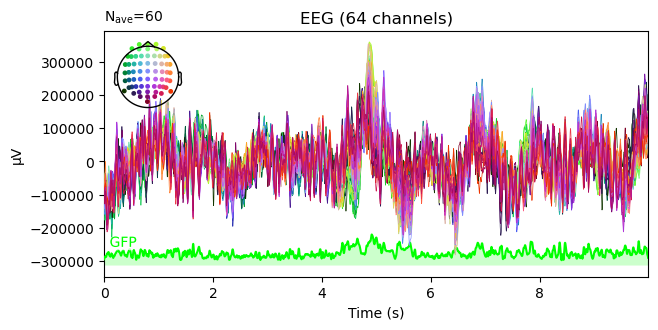

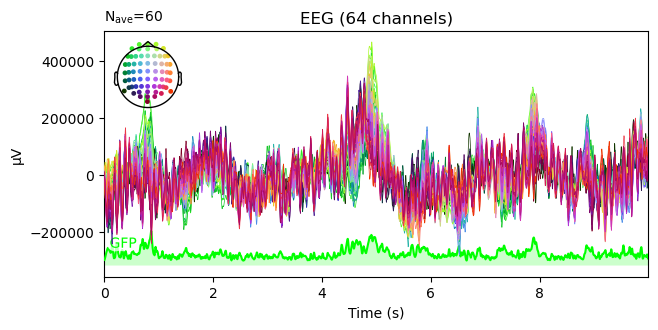

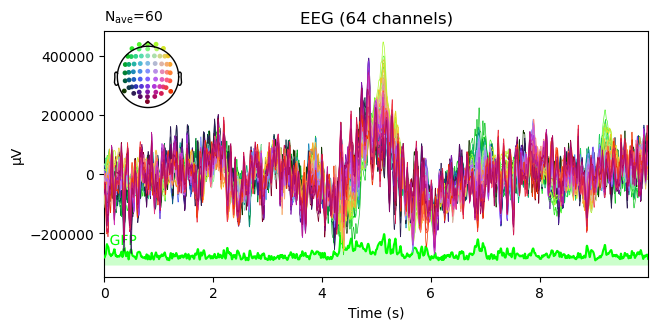

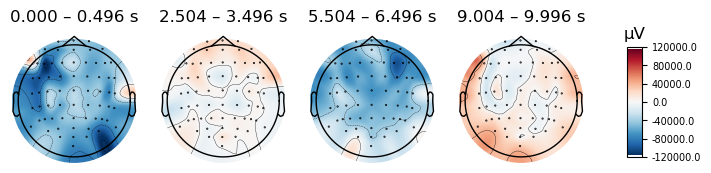

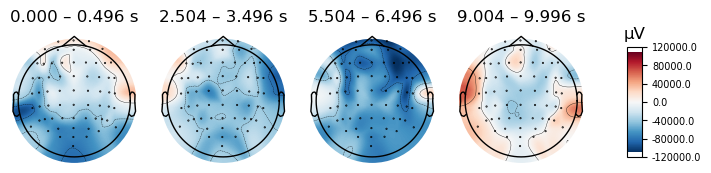

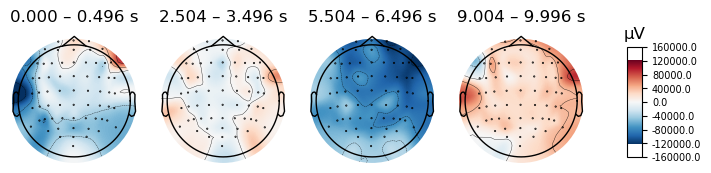

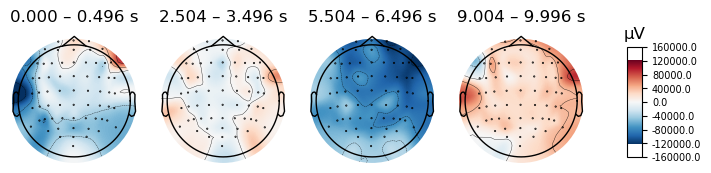

In [115]:
custom_epochs1 = mne.EpochsArray(processed_task1,info)
custom_epochs1.set_montage('standard_1020')
# custom_epochs1.resample(128)

task1_filtered  = custom_epochs1.filter(l_freq=0.5,h_freq=30)

custom_epochs2 = mne.EpochsArray(processed_task2,info)
custom_epochs2.set_montage('standard_1020')
#custom_epochs2.resample(128)
task2_filtered  = custom_epochs2.filter(l_freq=0.5,h_freq=30)

custom_epochs3 = mne.EpochsArray(processed_task3,info)
custom_epochs3.set_montage('standard_1020')
#custom_epochs3.resample(128)
task3_filtered  = custom_epochs3.filter(l_freq=0.5,h_freq=30)



ica1 = mne.preprocessing.ICA(n_components=20,random_state=42,max_iter=800)
ica2 = mne.preprocessing.ICA(n_components=20,random_state=42,max_iter=800)
ica3 = mne.preprocessing.ICA(n_components=20,random_state=42,max_iter=800)

ica1.fit(task1_filtered)
ica2.fit(task2_filtered)
ica3.fit(task3_filtered)

a = ica1.apply(task1_filtered)
b = ica2.apply(task2_filtered)
c = ica3.apply(task3_filtered)

ave1 = a.average()
ave2 = b.average()
ave3 = c.average()

ave1.resample(256)
ave2.resample(256)
ave3.resample(256)

# ave1_filtered = ave1.filter(l_freq=1,h_freq=40)
# ave2_filtered = ave2.filter(l_freq=1,h_freq=40)
# ave3_filtered = ave3.filter(l_freq=1,h_freq=40)


# ave1_filtered.plot(gfp=True)
# ave2_filtered.plot(gfp=True)
# ave3_filtered.plot(gfp=True)

ave1.plot(gfp=True)
ave2.plot(gfp=True)
ave3.plot(gfp=True)

# ave1.plot_topomap(times=[0,3,6,9.5],average=1,vlim=[-600000,600000])
# ave2.plot_topomap(times=[0,3,6,9.5],average=1,vlim=[-600000,600000])
# ave3.plot_topomap(times=[0,3,6,9.5],average=1,vlim=[-600000,600000])
ave1.plot_topomap(times=[0,3,6,9.5],average=1,ch_type="eeg")
ave2.plot_topomap(times=[0,3,6,9.5],average=1,ch_type="eeg")
ave3.plot_topomap(times=[0,3,6,9.5],average=1,ch_type="eeg")

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


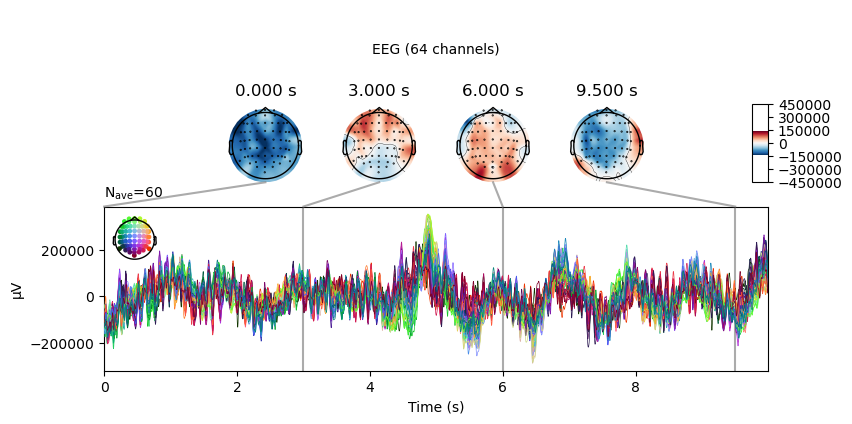

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


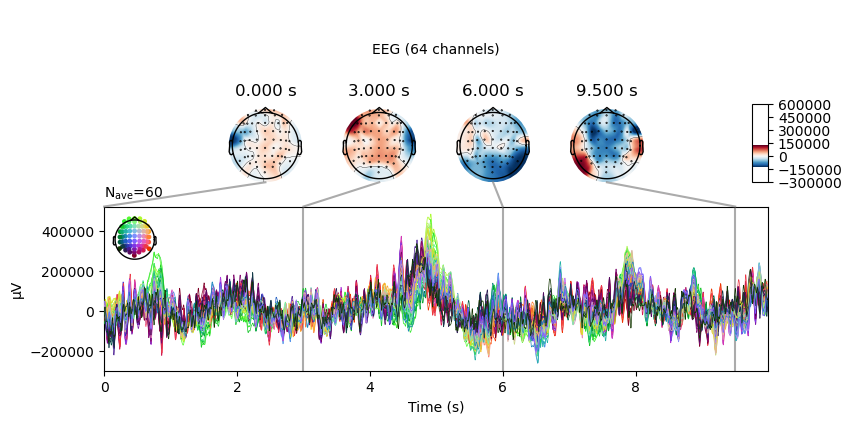

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


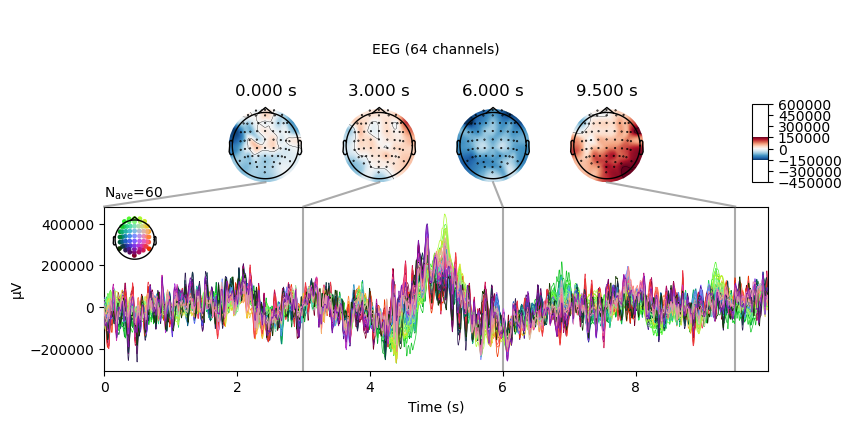

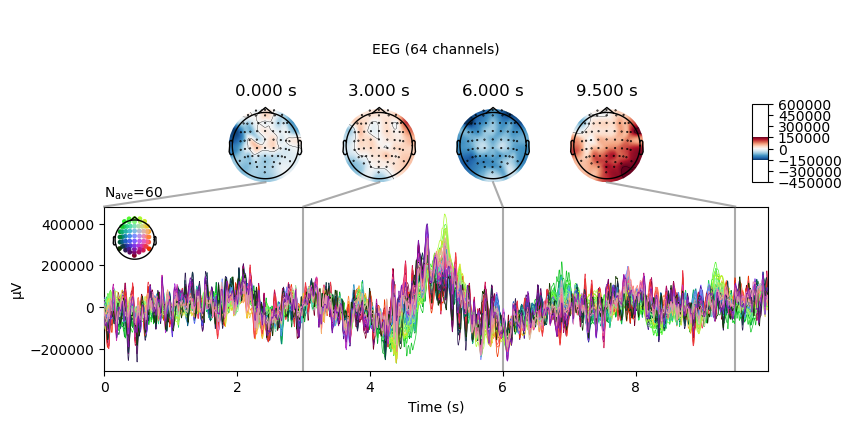

In [116]:
ave1.apply_baseline(baseline=(None, 4))
ave1.plot_joint(times=[0,3,6,9.5])
ave2.apply_baseline(baseline=(None, 4))
ave2.plot_joint(times=[0,3,6,9.5])
ave3.apply_baseline(baseline=(None, 4))
ave3.plot_joint(times=[0,3,6,9.5])

combining channels using "gfp"
combining channels using "gfp"


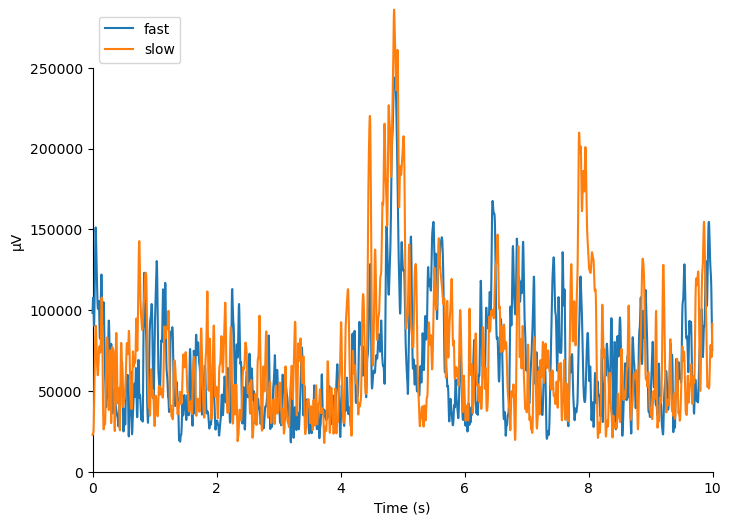

[<Figure size 800x600 with 1 Axes>]

In [133]:
mne.viz.plot_compare_evokeds(dict(fast=ave1,slow = ave2),combine = 'mean')

In [118]:
# ica.exclude = [1,2]
# ica.plot_properties(custom_epochs1,picks=ica.exclude)

In [119]:
# ica.apply(custom_epochs1)
# task1_ica = custom_epochs1.average()
# task1_ica.plot()
# task1_ica.plot_topomap(times=[0,3,6,9.5],average=1,vlim=[-600000,600000])

In [126]:
from scipy import fftpack
from scipy import signal
fs = 1024
f,t,Sxx1 = signal.spectrogram(ave1[0],fs,nperseg=516)
plt.figure()
plt.pcolormesh(t,f,Sxx1,vmax = 2e-5)
plt.ylim([0,50])
plt.colorbar()
plt.xlabel("Time[sec]")
plt.ylabel("Frequency[Hz]")
plt.show()

TypeError: 'EvokedArray' object is not subscriptable

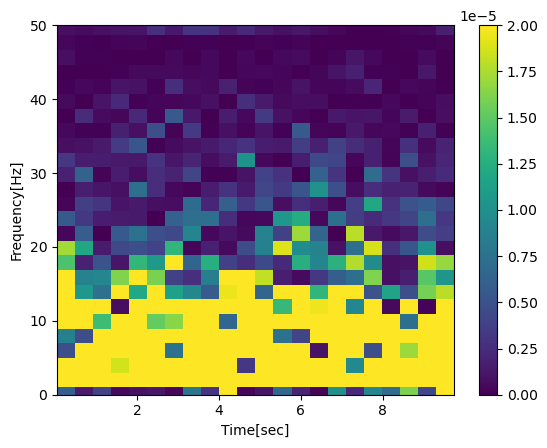

In [121]:
f,t,Sxx2 = signal.spectrogram(ave2[0],fs,nperseg=516)
plt.figure()
plt.pcolormesh(t,f,Sxx2,vmax = 2e-5)
plt.ylim([0,50])
plt.colorbar()
plt.xlabel("Time[sec]")
plt.ylabel("Frequency[Hz]")
plt.show()


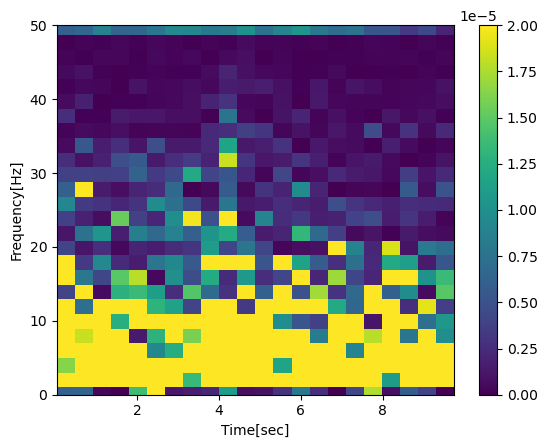

In [122]:
f,t,Sxx3 = signal.spectrogram(ave3[0],fs,nperseg=516)
plt.figure()
plt.pcolormesh(t,f,Sxx3,vmax = 2e-5)
plt.ylim([0,50])
plt.colorbar()
plt.xlabel("Time[sec]")
plt.ylabel("Frequency[Hz]")
plt.show()